In [1]:
#!pip install pandas
#!pip install requests
#!pip install gql
#!pip install python_dotenv
#!pip install requests-toolbelt
#!pip install matplotlib

In [2]:
import pandas as pd
from dotenv import load_dotenv
import os
from gql.transport.requests import RequestsHTTPTransport
from gql import Client, gql
import re
from matplotlib import pyplot as plt

In [3]:
#carrega a chave da API
load_dotenv("../.env")
token = os.getenv('GH_TOKEN')
if token is None:
    raise ValueError("GitHub token is not set. Check your .env file.")

In [4]:
# le a query
with open('../queries/bitcoin-core-comments.graphql', 'r') as file:
    query = file.read()
    
# inicializa cliente
transport = RequestsHTTPTransport(
    url='https://api.github.com/graphql',
    headers={'Authorization': f'token {token}'}
)
client = Client(transport=transport, fetch_schema_from_transport=True)

#executa query
query = gql(query)
result = client.execute(query)
result

{'repository': {'name': 'bitcoin',
  'description': 'Bitcoin Core integration/staging tree',
  'issues': {'edges': [{'node': {'title': 'JSON-RPC support for mobile devices ("ultra-lightweight" clients)',
      'body': 'The idea is to enable mobile or other not-always-connected-to-the-network clients, where the wallet is kept (encrypted, probably) on the mobile device, and the device periodically communicates with a bitcoin-network-connected node to:\n- Update balance for keys in its wallet\n- Submit signed transactions to the network\n',
      'createdAt': '2010-12-19T16:17:53Z',
      'comments': {'edges': [{'node': {'body': 'Yes, very important. If we enable mobile devices, pocket wallets will be soon obsolete ;-) GUI for smart-phones should include some QR reader, such as portapayment.com \n',
          'createdAt': '2011-02-07T13:43:11Z'}},
        {'node': {'body': '"Submit signed transactions to the network"\n\nI want that as well, for Google App Engine, where you cannot particip

In [5]:
def fetch_all_issues():
    issue_cursor = None
    comment_cursor = None
    issues_data = {}
    
    while True:
        variables = {
            'issueCursor': issue_cursor,
            'commentCursor': comment_cursor
        }

        # Execute query
        try:
            result = client.execute(query, variable_values=variables)
        except Exception as e:
            print(f"An error occurred: {e}")
            break
        
        issues = result.get('repository', {}).get('issues', {}).get('edges', [])
        
        for issue_edge in issues:
            issue = issue_edge.get('node', {})
            issue_body = issue.get('body', '')
            issue_created_at = issue.get('createdAt', '')

            # Save issue body and creation date
            issues_data[issue_created_at] = {
                'body': issue_body,
                'comments': []
            }

            # Collect comments
            comments = issue.get('comments', {}).get('edges', [])
            for comment_edge in comments:
                comment = comment_edge.get('node', {})
                comment_body = comment.get('body', '')
                issues_data[issue_created_at]['comments'].append(comment_body)
            
            # Next page of comments
            page_info = issue.get('comments', {}).get('pageInfo', {})
            comment_cursor = page_info.get('endCursor', None)
            if not page_info.get('hasNextPage', False):
                comment_cursor = None
        
        # Next page of issues
        page_info = result.get('repository', {}).get('issues', {}).get('pageInfo', {})
        issue_cursor = page_info.get('endCursor', None)
        if not page_info.get('hasNextPage', False):
            break
    
    return issues_data

data = fetch_all_issues()

In [6]:
def ethical_trends(issues_data, keywords):
    # Convert dictionary to DataFrame
    df = pd.DataFrame.from_dict(
        issues_data, 
        orient='index', 
        columns=['body']
    )
    
    # Add 'created_at' from index
    df.index.name = 'created_at'
    df.reset_index(inplace=True)
    
    # Extract date from index
    df['created_at'] = pd.to_datetime(df['created_at'])
    
    # Check if the issue contains ethical keywords
    df['contains_ethical'] = df['body'].apply(lambda x: any(re.search(r'\b' + re.escape(keyword) + r'\b', x, re.IGNORECASE) for keyword in keywords))
    
    # Set 'created_at' as the index
    df.set_index('created_at', inplace=True)
    
    # Resample by year and count the number of issues
    yearly_counts = df.resample('YE').size()
    
    # Plotting
    fig, ax = plt.subplots()
    yearly_counts.plot(ax=ax, marker='o', linestyle='-')
    plt.title('Total Number of Issues with ethical words per year')
    plt.xlabel('Year')
    plt.ylabel('Number of Issues')
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to fit labels and titles
    plt.show()

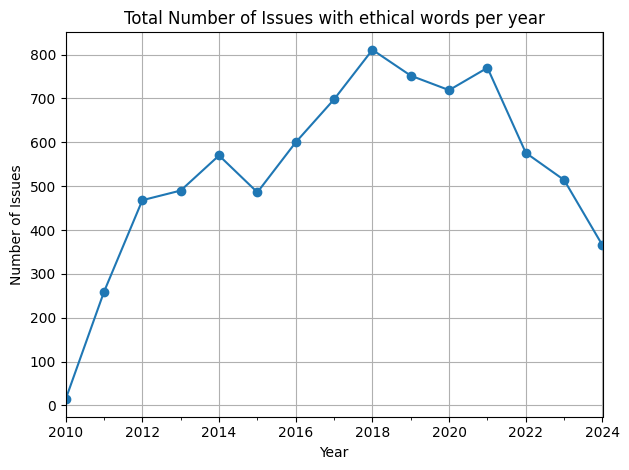

In [7]:
ethical_words = ['security', 'privacy', 'ethics', 'confidentiality', 'integrity']
ethical_trends(data, ethical_words)